In [3]:
ROOT_PATH = '../../../../'
MNIST_DATA_PATH = ROOT_PATH + 'assets/data/morphomnist/intensity_causes_thickness/'
BASE_LOG_PATH = ROOT_PATH + 'SVIExperimentReversedArrowsFinal/None/'

# Setup

In [4]:
%matplotlib inline
import sys
import os

sys.path.append(ROOT_PATH)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import inspect
from collections import OrderedDict
from functools import partial
import torch

import traceback
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

torch.autograd.set_grad_enabled(False);

In [5]:
from deepscm.datasets.morphomnist import MorphoMNISTLike

test_data = MorphoMNISTLike(MNIST_DATA_PATH, train=False, columns=['thickness', 'intensity'])

In [6]:
from deepscm.datasets.morphomnist.create_synth_thickness_intensity_data import model as true_model
from deepscm.experiments import morphomnist_reversed_arrows
from deepscm.experiments.morphomnist_reversed_arrows.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [7]:
def prep_data(batch):
    x = batch['image']
    thickness = batch['thickness'].unsqueeze(0).float()
    intensity = batch['intensity'].unsqueeze(0).float()

    x = x.float()

    x = x.unsqueeze(0).unsqueeze(0)

    return {'x': x, 'thickness': thickness, 'intensity': intensity}

In [8]:
from deepscm.morphomnist import measure
import multiprocessing

def measure_image(x, threshold=0.5, use_progress_bar=True):
    imgs = x.detach().cpu().numpy()[:, 0]

    with multiprocessing.Pool() as pool:
        measurements = measure.measure_batch(imgs, threshold=threshold, pool=pool)

    def get_intensity(imgs, threshold):

        img_min, img_max = imgs.min(axis=(1, 2), keepdims=True), imgs.max(axis=(1, 2), keepdims=True)
        mask = (imgs >= img_min + (img_max - img_min) * threshold)

        return np.array([np.median(i[m]) for i, m in zip(imgs, mask)])

    return measurements['thickness'].values, get_intensity(imgs, threshold)

In [9]:
from deepscm.submodules.morphomnist.morphomnist import io, morpho, perturb

images = io.load_idx(f'{MNIST_DATA_PATH}t10k-images-idx3-ubyte.gz')

In [17]:
# images = io.load_idx(f'{MNIST_DATA_PATH}t10k-images-idx3-ubyte.gz')

# thickened_images = np.empty_like(images)
# thinned_images = np.empty_like(images)

# for n in range(len(images)):
#     if n % 1000 == 0:
#         print(n)
#     morphology = morpho.ImageMorphology(images[n])
#     thick_img = morphology.downscale(perturb.Thickening(amount=1)(morphology))
#     thin_img = morphology.downscale(perturb.Thinning(amount=0.5)(morphology))
#     thinned_images[n] = thin_img
#     thickened_images[n] = thick_img

# io.save_idx(thickened_images, f'{MNIST_DATA_PATH}t10k-images-idx3-ubyte-thick.gz')
# io.load_idx(thinned_images, f'{MNIST_DATA_PATH}t10k-images-idx3-ubyte-thin.gz')
thickened_images = io.load_idx(f'{MNIST_DATA_PATH}t10k-images-idx3-ubyte-thick.gz')
thinned_images = io.load_idx(f'{MNIST_DATA_PATH}t10k-images-idx3-ubyte-thin.gz')

# Metrics

In [49]:
experiments = ['IndependentReversedVISEM', 'ConditionalDecoderReversedVISEM', 'ConditionalReversedVISEM']
versions = [9, 6, 9]

# Load Models

In [50]:
models = {'true': true_model,}

loaded_models = {}

for v, exp in zip(versions, experiments):
    try:
        checkpoint_path = f'{BASE_LOG_PATH}/{exp}/version_{v}/'

        base_path = os.path.join(checkpoint_path, 'checkpoints')
        checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

        ckpt = torch.load(checkpoint_path, map_location=torch.device('cuda'))
        hparams = ckpt['hyper_parameters']
        
        model_class = MODEL_REGISTRY[hparams['model']]

        model_params = {
            k: v for k, v in hparams.items() if (
                k in inspect.signature(model_class.__init__).parameters
                or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
                or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters
            )
        }
        
        new_state_dict = OrderedDict()

        for key, value in ckpt['state_dict'].items():
            new_key = key.replace('pyro_model.', '')
            new_state_dict[new_key] = value
            
        loaded_model = model_class(**model_params)
        loaded_model.load_state_dict(new_state_dict)
        
        for p in loaded_model._buffers.keys():
            if 'norm' in p:
                setattr(loaded_model, p, getattr(loaded_model, p))
                
        loaded_model.eval()
                
                
        loaded_models[exp] = loaded_model
        
        def sample_pgm(num_samples, model):
            with pyro.plate('observations', num_samples):
                return model.pgm_model()
        
        models[exp] = partial(sample_pgm, model=loaded_model)
    except Exception as e:
        print(e)
        traceback.print_exc()

In [13]:
def prep_data(batch):
    x = batch['image']
    thickness = batch['thickness'].unsqueeze(-1).float()
    intensity = batch['intensity'].unsqueeze(-1).float()

    x = x.float()

    x = x.unsqueeze(1)

    return {'x': x, 'thickness': thickness, 'intensity': intensity}

In [14]:
def get_counterfactuals_conds(x, intensity, thickness):
    _int_lower = intensity - 75
    _int_lower[_int_lower < 0] = 0
    # _thick_lower = thickness - 2
    # _thick_lower[_thick_lower < 0] = 0
    return {
        'do(i + 75)': {'intensity': intensity + 75},
        'do(i - 75)': {'intensity': _int_lower},
        'do(t + 2)': {'thickness': thickness * 2},
        'do(t - 2)': {'thickness': thickness / 2},
    }

In [24]:
from collections import defaultdict

batch_size = 5
data_len = 6 # len(test_data)
batches = data_len // batch_size
model_name = 'ConditionalReversedVISEM'

cfs = defaultdict(float)

for i in range(batches + 1):
    print(i)
    
    lb = i * batch_size
    if i == batches:
        ub = data_len # len(test_data)
    else:
        ub = i * batch_size + batch_size
    batch = prep_data(test_data[lb:ub])
    print(batch['x'].shape)
    
    cf_conds = get_counterfactuals_conds(batch['x'], batch['intensity'], batch['thickness'])
    
    recons = loaded_models[model_name].reconstruct(**batch, num_particles=hparams['num_sample_particles'])
    cfs['mae'] += np.abs((recons - batch['x'])).reshape(ub - lb, -1).mean(axis=1).sum()
    
    cfs_intensity_1 = loaded_models[model_name].counterfactual(
        obs=batch, condition=cf_conds['do(i + 75)'], num_particles=hparams['num_sample_particles'])
    cfs_intensity_2 = loaded_models[model_name].counterfactual(
        obs=batch, condition=cf_conds['do(i - 75)'], num_particles=hparams['num_sample_particles'])
    cfs_thickness_1 = loaded_models[model_name].counterfactual(
        obs=batch, condition=cf_conds['do(t + 2)'], num_particles=hparams['num_sample_particles'])
    cfs_thickness_2 = loaded_models[model_name].counterfactual(
        obs=batch, condition=cf_conds['do(t - 2)'], num_particles=hparams['num_sample_particles'])
    
    cfs_comb = np.vstack([
        cfs_intensity_1['x'],
        cfs_intensity_2['x'],
        cfs_thickness_1['x'],
        cfs_thickness_2['x']
    ])
    
    preds = measure_image(torch.tensor(cfs_comb))
    
    thickness_pred = preds[0].reshape(-1, ub - lb)
    intensity_pred = preds[1].reshape(-1, ub - lb)
    
    int_mae_1 = np.abs(cf_conds['do(i + 75)']['intensity'].flatten() - np.nan_to_num(intensity_pred[0])).sum()
    int_mae_2 = np.abs(cf_conds['do(i - 75)']['intensity'].flatten() - np.nan_to_num(intensity_pred[1])).sum()
    thick_mae_1_measure = np.abs(cf_conds['do(t + 2)']['thickness'].flatten() - np.nan_to_num(thickness_pred[2])).sum()
    thick_mae_2_measure = np.abs(cf_conds['do(t - 2)']['thickness'].flatten() - np.nan_to_num(thickness_pred[3])).sum()
    
    cfs['do(i + 75)'] += int_mae_1
    cfs['do(i - 75)'] += int_mae_2
    cfs['do(t + 2)_measure'] += thick_mae_1_measure
    cfs['do(t - 2)_measure'] += thick_mae_2_measure
    
    t_1 = cfs_thickness_1['x'].squeeze(1).numpy()
    t_2 = cfs_thickness_2['x'].squeeze(1).numpy()
    thick_mae_1 = (thickened_images[lb:ub] - t_1).reshape(ub - lb, -1).sum() / 255
    thick_mae_2 = (thinned_images[lb:ub] - t_2).reshape(ub - lb, -1).sum() / 255
    cfs['do(t + 2)'] += thick_mae_1
    cfs['do(t - 2)'] += thick_mae_2
    
    print(int_mae_1, int_mae_2, thick_mae_1_measure, thick_mae_2_measure, thick_mae_1, thick_mae_2)
    break

for k in cfs.keys():
    cfs[k] /= data_len

0
torch.Size([5, 1, 28, 28])


  0%|          | 0/20 [00:00<?, ?img/s]/vol/bitbucket/rrr2417/deepscm/ENV2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|##########| 20/20 [00:02<00:00,  7.47img/s]


tensor(47.7741) tensor(43.8682) tensor(21.8429, dtype=torch.float64) tensor(5.4607, dtype=torch.float64) nan nan


In [ ]:
plt.imshow(thickened_images[n])

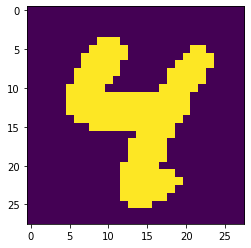

In [302]:
plt.imshow(thickened_images[n])

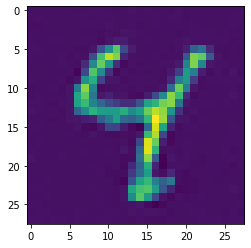

In [303]:
plt.imshow(images[n])

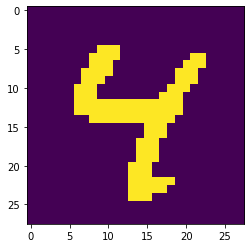

In [304]:
plt.imshow(thinned_images[n])

In [252]:
cfs

defaultdict(float,
            {'mae': tensor(4.4578),
             'do(i + 75)': tensor(75.4604),
             'do(i - 75)': tensor(74.5287),
             'do(t + 2)': tensor(2.3822, dtype=torch.float64),
             'do(t - 2)': tensor(1.3453, dtype=torch.float64)})

In [65]:
conds = ['recon', 'do(i + 75)', 'do(i - 75)', 'do(t + 2)', 'do(t - 2)']
test_sets = ['', '_i_100', '_i_m_75', '_t_2', '_t_m_1_5']

from deepscm.datasets.morphomnist import load_morphomnist_like, save_morphomnist_like


for cond, test_set in zip(conds, test_sets):
    print(cond)
    for (name, _), version in zip(loaded_models.items(), versions):
        print(name, version) # , model)
        if cond == 'recon':
            preds = f'{ROOT_PATH}{name}_version_{version}_recon.npy'
            preds = np.load(preds)
        else:
            preds = np.load(f'{ROOT_PATH}/{name}_main_version_{version}_{cond}.npy')
        test_data_path = f'{ROOT_PATH}assets/data/morphomnist/intensity_causes_thickness{test_set}/'
#         print(test_data_path)
        true, _, _ = load_morphomnist_like(test_data_path, train=False)
        preds = np.squeeze(preds, 1).reshape(10000, -1)
        preds[np.isnan(preds)] = 0
        loss = torch.nn.functional.l1_loss(
            torch.tensor(preds),
            torch.tensor(true.reshape(10000, -1))
        )
        print(loss)
    print()

recon
IndependentReversedVISEM 9
tensor(4.5369)
ConditionalDecoderReversedVISEM 6
tensor(4.3811)
ConditionalReversedVISEM 9
tensor(4.4236)

do(i + 75)
IndependentReversedVISEM 9
tensor(29.1952)
ConditionalDecoderReversedVISEM 6
tensor(22.4278)
ConditionalReversedVISEM 9
tensor(14.1705)

do(i - 75)
IndependentReversedVISEM 9
tensor(14.7932)
ConditionalDecoderReversedVISEM 6
tensor(7.7850)
ConditionalReversedVISEM 9
tensor(6.3301)

do(t + 2)
IndependentReversedVISEM 9
tensor(15.7672)
ConditionalDecoderReversedVISEM 6
tensor(10.7237)
ConditionalReversedVISEM 9
tensor(12.1844)

do(t - 2)
IndependentReversedVISEM 9
tensor(13.0702)
ConditionalDecoderReversedVISEM 6
tensor(7.1295)
ConditionalReversedVISEM 9
tensor(7.1880)



In [57]:
%%bash
ls -la ../../../../assets/data/morphomnist/intensity_causes_thickness_t_2

total 2409
drwxr-xr-x  2 rrr2417 cs4       6 Jun 11 02:16 .
drwxr-xr-x 18 rrr2417 cs4      25 Jun 11 00:52 ..
-rw-r--r--  1 rrr2417 cs4     231 Jun 11 00:46 args.txt
-rw-r--r--  1 rrr2417 cs4 2143742 Jun 11 02:16 t10k-images-idx3-ubyte.gz
-rw-r--r--  1 rrr2417 cs4    5131 Jun 11 02:16 t10k-labels-idx1-ubyte.gz
-rw-r--r--  1 rrr2417 cs4  265754 Jun 11 02:16 t10k-morpho.csv
